
Author: yanjun zhang

## Concise
## 1: Start

Source from 
book "Abali - 2017 - Computational Reality" P119

import dolfinx
print(f"DOLFINx version: {dolfinx.__version__}   \
based on GIT commit:  \
{dolfinx.git_commit_hash} of https://github.com/FEniCS/dolfinx/")

/home/yanjun/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


1: Total tims is  42.19 s
2: Total numb steps is  3


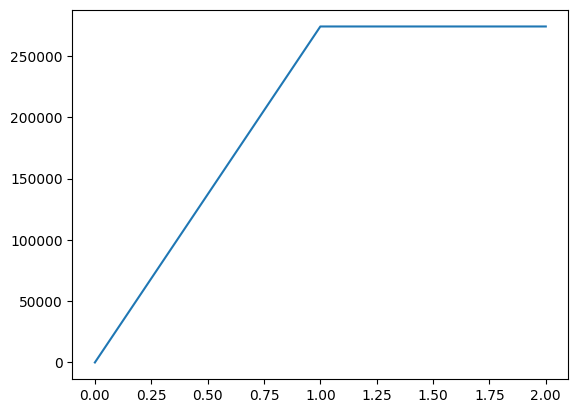

In [1]:
# import basic
import pyvista
import ufl
import dolfinx
import time
import sys
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

# import speciail library
from dolfinx.fem.petsc import LinearProblem, assemble_vector, assemble_matrix, create_vector, apply_lifting, set_bc
from dolfinx           import fem, mesh, io, plot, default_scalar_type, nls, log
from dolfinx.fem       import Constant, dirichletbc, Function, FunctionSpace,form,locate_dofs_topological
from dolfinx.io        import XDMFFile, gmshio
from dolfinx.mesh      import locate_entities,locate_entities_boundary,meshtags
from ufl               import SpatialCoordinate, TestFunction, TrialFunction, dx, grad, inner, Measure, dot, FacetNormal
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from petsc4py          import PETSc
from mpi4py            import MPI

# import own functions
from brake_disc_functions import *

# calculate how long time the simulation it is 
start_time = time.time()

# mesh-size, contact area coefficient
mesh_min = 3
mesh_max = 10
c_contact = 1

# Each time step rotation angular, and acc during lag, 1 is full acc, 0 is no acc. 
angular_r = 36000*4
v_vehicle = 160 
c_acc = 1

# calling local functions to get all parameters
dt,P,g,num_steps,h,radiation,v_angular,Ti,Tm,S_rub_circle,t,rho,c,k,t_brake,S_total \
                = vehicle_initial (angular_r, v_vehicle, c_contact, c_acc)

print('1: Total tims is ', round(sum(dt),2), 's')
print('2: Total numb steps is ', num_steps)
plt.plot(P)

## 2: Mesh

In [2]:
######################################  mesh  ###################################3
mesh_name = f"{mesh_min}-{mesh_max}"
mesh_filename1 = "m-{}.msh".format(mesh_name)  
mesh_filename2 = "m-{}".format(mesh_name)  

if os.path.exists(mesh_filename1):
    # Run this command if the file exists
    print(f"The file '{mesh_filename1}' exists, start creat now:")
    domain, cell_markers, facet_markers = gmshio.read_from_msh(mesh_filename1, MPI.COMM_WORLD, 0, gdim=3)

else:
    # Run this command if the file does not exist
    print(f"The file '{mesh_filename1}' does not exist, start building:")
    mesh_brake_disc(mesh_min, mesh_max,mesh_filename2)
    domain, cell_markers, facet_markers = gmshio.read_from_msh(mesh_filename1, MPI.COMM_WORLD, 0, gdim=3)

# Define variational problem, Here Lagrange changes to CG, what is CG?
V = fem.FunctionSpace(domain, ('CG', 1))

# initialization
def project(function, space):
    u = TrialFunction(space)
    v = TestFunction(space)
    a = inner(u, v) * dx
    L = inner(function, v) * dx
    problem = LinearProblem(a, L, bcs = [])
    return problem.solve()
    
# u_n is for initial condition and uh is the solver result.
# variable, need to be projected form Q onto V
Q = FunctionSpace(domain, ("DG", 0))
T_init = Function(Q)
T_init.name = "u_n"
T_init.x.array[:] = np.full_like(1, Ti, dtype=default_scalar_type)
u_n = project(T_init,V)
u_n.name = "u_n"

fdim = domain.topology.dim - 1
## bc_disc is zero, no any dirichlete boundary condition
bc_disc = mesh.locate_entities_boundary(
    domain, fdim , lambda x:  np.isclose(x[2], 50) )
bc = fem.dirichletbc(PETSc.ScalarType(Tm), fem.locate_dofs_topological(V, fdim, bc_disc), V)
np.set_printoptions(threshold=np.inf)

import meshio
mesh1= meshio.read(mesh_filename1)
total_elements = sum( len(cells.data) for cells in mesh1.cells )

The file 'm-3-10.msh' exists, start creat now:
Info    : Reading 'm-3-10.msh'...
Info    : 168 entities
Info    : 10751 nodes
Info    : 43604 elements
Info    : Done reading 'm-3-10.msh'



## 3: Setup 


In [3]:
xdmf_name = "T-s-{}-d-{}-{}-c-{}-e-{}.xdmf".format(num_steps, angular_r, mesh_filename2,c_contact,total_elements)
h5_name = "T-s-{}-d-{}-{}-c-{}-e-{}.h5".format(num_steps, angular_r, mesh_filename2,c_contact,total_elements)
xdmf = io.XDMFFile(domain.comm, xdmf_name, "w")
xdmf.write_mesh(domain)

# Create boundary condition

x_co, y_co = get_rub_coordinate()

common_indices3,facet_markers3,sorted_indices3 = target_facets(domain,x_co,y_co,S_rub_circle)
      
facet_tag = meshtags(domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3])
ds = Measure('ds', domain=domain, subdomain_data=facet_tag) 


## 4: Variational equation


In [4]:
uh = fem.Function(V)
uh.name = "uh"
uh = project(T_init,V)
t = 0
xdmf.write_function(uh, t)

#u = ufl.TrialFunction(V)
u = fem.Function(V)

v = ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(0))
n_vector = FacetNormal(domain)

F = (rho*c)/dt[0]*inner(u,v)*dx + k*inner(grad(u),grad(v))*dx+  h*inner(u,v)*ds(200) + radiation*inner(u**4,v) *ds(200) \
- ( inner(f,v) *dx + (rho*c)/dt[0] * inner(u_n, v) * dx +  h * Tm * v *ds(200) +  radiation * (Tm**4)* v *ds(200) )


for i in list(range(1,19)):
     F +=  - k * dot( grad(u)* v, n_vector) *ds(10*i) - inner(g[0], v) *ds(10*i)

problem = NonlinearProblem(F, u, bcs=[bc])

## 7: Using petsc4py to create a linear solver
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-6
solver.report = True

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

log.set_log_level(log.LogLevel.INFO)
n, converged = solver.solve(u)
assert (converged)


## 8:Visualization of time dependent problem using pyvista
import matplotlib as mpl
pyvista.start_xvfb()
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))
plotter = pyvista.Plotter()

gif_name = "T-s-{}-d-{}-{}-c-{}-e-{}.gif".format(num_steps, angular_r, mesh_filename2,c_contact,total_elements)

plotter.open_gif(gif_name, fps=30)
grid.point_data["Temperature"] = u.x.array
warped = grid.warp_by_scalar("Temperature", factor=0)
viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
sargs = dict(title_font_size=25, label_font_size=20,  color="black",
             position_x=0.1, position_y=0.8, width=0.8, height=0.1)
renderer = plotter.add_mesh(warped, show_edges=True, lighting=False,
                            cmap=viridis, scalar_bar_args=sargs,
                            #clim=[0, max(uh.x.array)])
                            clim=[0,  200])

2024-05-02 09:26:46.407 (   6.187s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-02 09:26:46.502 (   6.281s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-02 09:26:46.585 (   6.365s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.128772 (tol = 1e-10) r (rel) = 2.06986e-05(tol = 1e-06)
2024-05-02 09:26:46.623 (   6.403s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-02 09:26:46.693 (   6.477s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 4.64153e-07 (tol = 1e-10) r (rel) = 7.46068e-11(tol = 1e-06)
2024-05-02 09:26:46.698 (   6.478s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 3 iterations and 14 linear solver iterations.


## 5: Solution


In [5]:

T_array = [(0, [Ti for _ in range( len(u.x.array))] )]
total_degree = 0

for i in range(num_steps):
    t += dt[i] 
 
    x_co, y_co = rub_rotation (x_co, y_co, angular_r)   # update the location
    total_degree += angular_r  # Incrementing degree by 10 in each step
    
    sys.stdout.write('\r1: Rotation has applied for {} degree. '.format(total_degree))
    sys.stdout.write('2: Current time is ' + str(round(t,1)) + " s. ")
    sys.stdout.write('3: Completion is '  + str(round (100*(t/t_brake),1) )+ " %. ")
    sys.stdout.flush()
    
    common_indices3,facet_markers3,sorted_indices3 = target_facets(domain,x_co,y_co,S_rub_circle)      
    facet_tag = meshtags(domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3])
    ds = Measure('ds', domain=domain, subdomain_data=facet_tag) 

    F = (rho*c)/dt[i]*inner(u,v)*dx + k*inner(grad(u),grad(v))*dx+  h*inner(u,v)*ds(200) + radiation*inner(u**4,v) *ds(200) \
    - ( inner(f,v) *dx + (rho*c)/dt[i] * inner(u_n, v) * dx +  h * 25* v *ds(200) +  radiation * (25**4)* v *ds(200) )

    for j in list(range(1,19)):
         F +=  - k * dot( grad(u)* v, n_vector) *ds(10*j) - inner(g[i], v) *ds(10*j)

    problem = NonlinearProblem(F, u, bcs=[bc])

    ## 7: Using petsc4py to create a linear solver
    solver = NewtonSolver(MPI.COMM_WORLD, problem)
    solver.convergence_criterion = "incremental"
    solver.rtol = 1e-6
    
    ksp = solver.krylov_solver
    opts = PETSc.Options()
    option_prefix = ksp.getOptionsPrefix()
    opts[f"{option_prefix}ksp_type"] = "cg"
    opts[f"{option_prefix}pc_type"] = "gamg"
    opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
    ksp.setFromOptions()

    sys.stdout.write('1: Completion is '  + str(round (100*(t/t_brake),1) )+ " %. ")
    sys.stdout.flush()

    solver.solve(u)
    u.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = u.x.array
    
    T_array.append( (t, u.x.array.copy() ) )
    # Write solution to file
    xdmf.write_function(u, t)
    # Update plot
    #warped = grid.warp_by_scalar("uh", factor=0)
    plotter.update_coordinates(warped.points.copy(), render=False)
    plotter.update_scalars(u.x.array, render=False)
    plotter.write_frame()
    
plotter.close() 
xdmf.close()
print()

csv_name = "Result_T-s-{}-d-{}-{}-c-{}-e-{}.csv".format(num_steps, angular_r, mesh_filename2,c_contact,total_elements)
save_t_T(csv_name,T_array)

1: Rotation has applied for 144000 degree. 2: Current time is 26.0 s. 3: Completion is 53.1 %. 

2024-05-02 09:26:49.928 (   9.707s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-05-02 09:26:49.928 (   9.708s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-05-02 09:26:49.928 (   9.708s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-05-02 09:26:49.928 (   9.708s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-05-02 09:26:49.933 (   9.713s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-05-02 09:26:49.933 (   9.713s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-05-02 09:26:49.935 (   9.715s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-05-02 09:26:49.944 (   9.724s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-05-02 09:26:49.944 (   9.724s) [mai

1: Completion is 53.1 %. 

2024-05-02 09:26:52.562 (  12.342s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-02 09:26:52.563 (  12.342s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-02 09:26:52.564 (  12.344s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-02 09:26:52.564 (  12.344s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-02 09:26:52.569 (  12.349s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-02 09:26:52.592 (  12.371s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-02 09:26:52.656 (  12.436s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-02 09:26:52.780 (  12.560s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 288000 degree. 2: Current time is 81.5 s. 3: Completion is 166.2 %. 

2024-05-02 09:26:53.386 (  13.166s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-05-02 09:26:53.387 (  13.167s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-05-02 09:26:53.387 (  13.167s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-05-02 09:26:53.387 (  13.167s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-05-02 09:26:53.388 (  13.167s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-05-02 09:26:53.388 (  13.167s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-05-02 09:26:53.388 (  13.168s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-05-02 09:26:53.388 (  13.168s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-05-02 09:26:53.388 (  13.168s) [mai

1: Completion is 166.2 %. 

2024-05-02 09:26:55.902 (  15.681s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-02 09:26:55.902 (  15.681s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-02 09:26:55.903 (  15.682s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-02 09:26:55.903 (  15.682s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-02 09:26:55.909 (  15.689s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-02 09:26:55.925 (  15.705s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-02 09:26:55.976 (  15.756s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-02 09:26:56.150 (  15.930s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system

1: Rotation has applied for 432000 degree. 2: Current time is 42.2 s. 3: Completion is 86.1 %. 

2024-05-02 09:26:56.578 (  16.357s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 4: r (abs) = 159.074 (tol = 1e-10) r (rel) = 0.0026213(tol = 1e-06)
2024-05-02 09:26:56.606 (  16.386s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-02 09:26:56.688 (  16.468s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 5: r (abs) = 0.723221 (tol = 1e-10) r (rel) = 1.19176e-05(tol = 1e-06)
2024-05-02 09:26:56.712 (  16.492s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-02 09:26:56.772 (  16.552s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 6: r (abs) = 1.95528e-05 (tol = 1e-10) r (rel) = 3.222e-10(tol = 1e-06)
2024-05-02 09:26:56.773 (  16.552s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 6 iterations and 42 linear solver iterations.
2024-05-02 09:26:56.773 (  16.553s

1: Completion is 86.1 %. 

2024-05-02 09:26:59.189 (  18.969s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-02 09:26:59.190 (  18.969s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-02 09:26:59.191 (  18.970s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-02 09:26:59.191 (  18.970s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-05-02 09:26:59.196 (  18.976s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-05-02 09:26:59.213 (  18.992s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-05-02 09:26:59.254 (  19.033s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2024-05-02 09:27:22.034 (  41.814s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system


t and T have been successfully saved as Result_T-s-3-d-144000-m-3-10-c-1-e-43604.csv


# 6: Post process

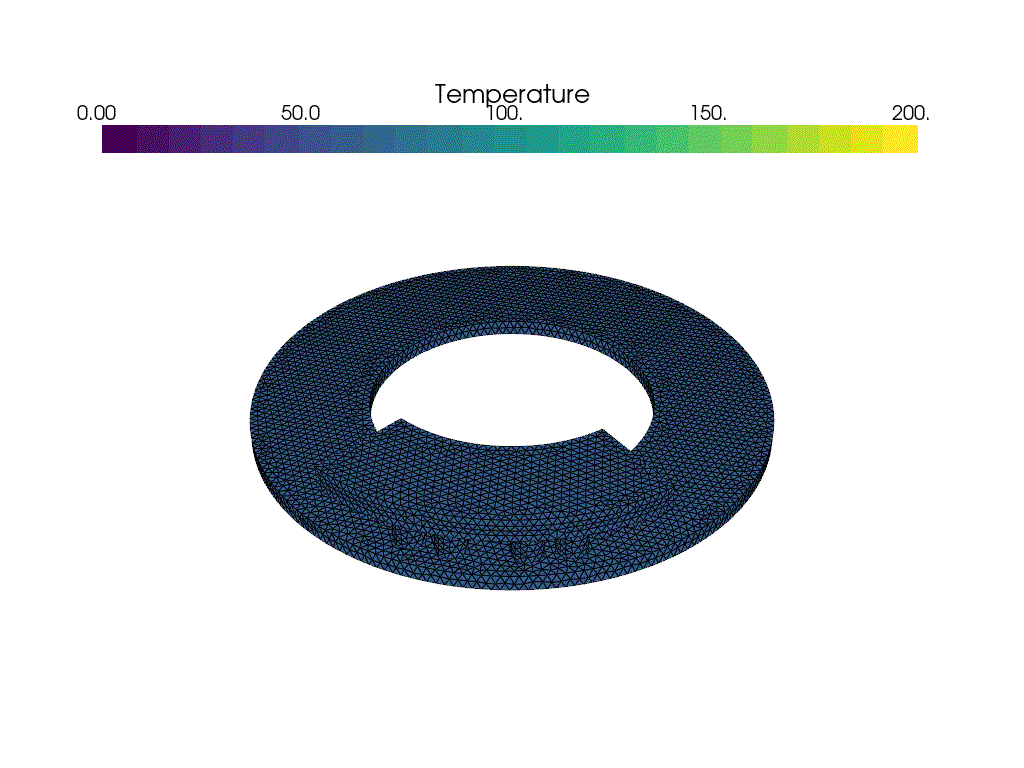

1: Start at: 2024-05-02 09:26:40
2: End at 2024-05-02 09:27:22
3: Simulation time is 42.0 second
1: First time step dt is  26.01239 s
2: Convection heat transfer coefficient is 7.75e-05  W/mm2 K
3: Radiation is  3.6e-13  W/mm2 K-4
4: Each rotation degree is  144000  per time step or  400.0  circle
5: The first rotation degree is  628318.5
6: The mid rotation degree is  628318.5
7: The last rotation degree is  628318.5
9: Total contact area of 18 rubbing element is 199.9 cm2
10: The mesh element size is between  3 - 10 mm

Move files successfully


In [6]:
# Display the GIF
from IPython.display import display, Image
display( Image(gif_name) )

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time1 = round(elapsed_time, 0)

formatted_start_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time))
formatted_end_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time))
txt_name = "T-s-{}-d-{}-{}-c-{}-e-{}.txt".format(num_steps, angular_r, mesh_filename2,c_contact,total_elements)
with open(txt_name, "w") as file:
   original_print = print
   print = lambda *args, **kwargs: original_print(*args, **kwargs, file=file)
    
   print("1: Start at:", formatted_start_time)
   print('2: End at', formatted_end_time)
    
   if elapsed_time1 >= 60:
      min = elapsed_time1/60
      hours = min/60
      print("3: Simulation time is",round(hours), 'hours', round(min),'minutes')
   else:
      print("3: Simulation time is",elapsed_time1, 'second')

   print('1: First time step dt is ', round(dt[0],5),'s')
   r_disc = 0.25

   print('2: Convection heat transfer coefficient is',h, ' W/mm2 K')
   print('3: Radiation is ', round(radiation,14), ' W/mm2 K-4')
   print('4: Each rotation degree is ', round(angular_r,1), ' per time step', 'or ', round(angular_r/360,1),' circle')
   print('5: The first rotation degree is ', round(v_angular[0] * r_disc * dt[0] *1000, 1) )
   print('6: The mid rotation degree is ', round(v_angular[ round(num_steps/2) ] * r_disc * dt[ round(len(dt)/2) ] *1000, 1) )
   print('7: The last rotation degree is ', round(v_angular[num_steps-1] * r_disc * dt[-1] *1000, 1) )
   print('9: Total contact area of 18 rubbing element is', round(S_total/100,1), 'cm2')
   print('10: The mesh element size is between ',mesh_min, '-',mesh_max, 'mm' )
   #print('11: Total elements number is ',total_elements )    

print = original_print 
with open(txt_name, "r") as file1:
   print( file1.read() )

#### move files
# Define the source directory
source_dir = "/home/yanjun/Documents/FEniCSx/Practice/Concise"
# Define the destination directory
destination_dir = "/home/yanjun/Documents/FEM_results"

# Create the new folder in the destination directory
new_folder_name = f"s-{num_steps}-d-{angular_r}-m-{mesh_min}-{mesh_max}-c-{c_contact}-e-{total_elements}"
destination_dir = os.path.join(destination_dir, new_folder_name)
os.makedirs(destination_dir, exist_ok=True)

# List of files to move
files_to_move = [
                 gif_name,
                 h5_name,
                 xdmf_name,
                 txt_name,
                 csv_name
                           ]
# Move each file to the destination directory
for filename in files_to_move:
    source_file_path = os.path.join(source_dir, filename)
    destination_file_path = os.path.join(destination_dir, filename)
    shutil.move(source_file_path, destination_file_path)
print('Move files successfully')

Total nodes extracted: 10751


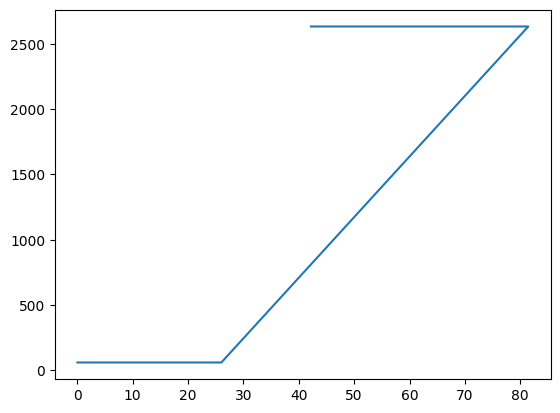

In [7]:
## get t and temperature T form T_array matrix
t, T = [], []
for value in T_array:
    t.append(value[0])
    T.append(value[1])

## get nodes which only in friction surface
filename = mesh_filename1
nodes,node_tag = read_msh_file(filename)
print("Total nodes extracted:", len(nodes))  # Check the total number of nodes extracted

## get T_all with only friction surface
T_friction = []
T_all = []
for i in range(len(T)):
    T_friction = []
    for tag in node_tag:
       T_friction.append(T[i][tag-1])
    T_all.append(T_friction)
    
## get T_max in friciton surface

T_max = []
for i in range(len(T_all)):
    T_max.append( max(T_all[i]) )
      
plt.plot(t,T_max)

Lables already exists, for mesh m-3-10.msh is  [3157, 7018, 2141]


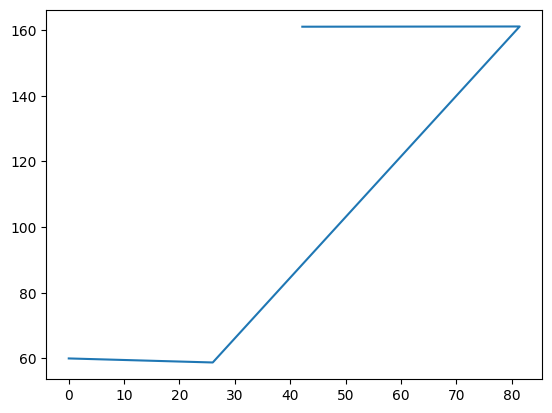

In [8]:
from brake_disc_functions import *
lables = find_3_coord(mesh_filename1)

t, T = [], []
for value in T_array:
    t.append(value[0])
    T.append(value[1])

T_3_ave = []
for i in range(len(T)):
    T_3_all =  T[i][ lables[0] ] + T[i][ lables[1] ] + T[i][ lables[2] ]   
    T_3_ave.append ( T_3_all / 3 )

plt.plot(t,T_3_ave)
     

In [9]:
lables = find_3_coord(mesh_filename1)
#T_3_labels = 3157, 7018, 2141
#for i in range(len(T)):
 #   print( T[i][T_3_labels[1]] )

Lables already exists, for mesh m-3-10.msh is  [3157, 7018, 2141]


In [11]:
print(F)

{ -9.235982697593466e-05 * f * (conj((v_0))) } * dx(<Mesh #0>[everywhere], {})
  +  { 0.048 * (conj(((grad(v_0)) : (grad(f))))) } * dx(<Mesh #0>[everywhere], {})
  +  { -1 * c_0 * (conj((v_0))) } * dx(<Mesh #0>[everywhere], {})
  +  { -1 * -9.235982697593466e-05 * u_n * (conj((v_0))) } * dx(<Mesh #0>[everywhere], {})
  +  { -0.048 * (({ A | A_{i_{2444}} = (grad(f))[i_{2444}] * v_0 }) . (n)) } * ds(<Mesh #0>[10], {})
  +  { -1 * -2.9033162281814873 * (conj((v_0))) } * ds(<Mesh #0>[10], {})
  +  { -0.048 * (({ A | A_{i_{2445}} = (grad(f))[i_{2445}] * v_0 }) . (n)) } * ds(<Mesh #0>[20], {})
  +  { -1 * -2.9033162281814873 * (conj((v_0))) } * ds(<Mesh #0>[20], {})
  +  { -0.048 * (({ A | A_{i_{2446}} = (grad(f))[i_{2446}] * v_0 }) . (n)) } * ds(<Mesh #0>[30], {})
  +  { -1 * -2.9033162281814873 * (conj((v_0))) } * ds(<Mesh #0>[30], {})
  +  { -0.048 * (({ A | A_{i_{2447}} = (grad(f))[i_{2447}] * v_0 }) . (n)) } * ds(<Mesh #0>[40], {})
  +  { -1 * -2.9033162281814873 * (conj((v_0))) } * ds(